**Nasywa Agiyan Nisa**

**MC-28**

**Proyek Sistem Rekomendasi**

## **Overview**
Dalam era digital yang dipenuhi oleh berbagai pilihan hiburan, menemukan anime yang sesuai dengan preferensi individu bisa menjadi tantangan. Oleh karena itu, proyek ini bertujuan untuk membangun sistem rekomendasi anime yang cerdas dengan memanfaatkan pendekatan *Content-Based Filtering* dan *Collaborative Filtering*. Dengan menggabungkan kedua metode ini, sistem dapat memberikan rekomendasi yang lebih akurat dan personal, baik berdasarkan kesamaan konten maupun pola kesukaan pengguna lain yang serupa.


## **1. Data Collection**

Tujuan dari tahap data collection dalam proyek sistem rekomendasi anime adalah untuk mengumpulkan data mentah yang akan menjadi dasar dari seluruh proses analisis dan pembangunan model. Tanpa data yang relevan dan representatif, model tidak akan mampu belajar pola preferensi pengguna atau memahami karakteristik setiap anime.

#### Import Library yang dibutuhkan

In [1]:
# Impor Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import shutil
import zipfile

!pip install -q kaggle

Unggah file kaggle.json untuk dapat terhubungan dengan kaggle dataset.

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nasywaagiyann","key":"427392d29278d314fe42416a17ebfcf9"}'}

In [3]:
# Membuat direktori .kaggle jika belum ada
os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke folder .kaggle
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Ubah permission agar tidak terbaca publik
os.chmod("/root/.kaggle/kaggle.json", 600)


#### Mengunduh dataset dari Kaggle dengan mengunakan Kaggle API.

In [4]:
!kaggle datasets download -d hernan4444/animeplanet-recommendation-database-2020


Dataset URL: https://www.kaggle.com/datasets/hernan4444/animeplanet-recommendation-database-2020
License(s): CC0-1.0
animeplanet-recommendation-database-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


#### Ekstrak zip file

In [5]:
with zipfile.ZipFile("animeplanet-recommendation-database-2020.zip", "r") as zip_ref:
    zip_ref.extractall("animeplanet_data")

# Lihat isinya
!ls animeplanet_data

 anime.csv	 anime_recommendations.csv   rating_complete.csv
 animelist.csv	'html folder'		     watching_status.csv


#### Membaca berbagai dataset dari Anime-Planet Recommendation Database 2020

In [6]:
anime_df = pd.read_csv("animeplanet_data/anime.csv")                  # Data utama tentang anime
animelist_df = pd.read_csv("animeplanet_data/animelist.csv")          # Data daftar anime pengguna
recommendations_df = pd.read_csv("animeplanet_data/anime_recommendations.csv")  # Data rekomendasi antar anime
rating_df = pd.read_csv("animeplanet_data/rating_complete.csv")       # Data rating lengkap dari pengguna
status_df = pd.read_csv("animeplanet_data/watching_status.csv")       # Data status menonton pengguna


## **2. Data Understanding**

Data Understanding itu tahap penting dalam proses analisis data atau machine learning. Fungsinya adalah untuk mengenal dan memahami data sebelum mulai diproses lebih lanjut.

#### Memuat dan Memeriksa Dimensi Dataset

In [7]:
# Membuat dictionary yang memetakan nama file dataset ke DataFrame yang sesuai
datasets = {
    "anime.csv": anime_df,
    "animelist.csv": animelist_df,
    "anime_recommendations.csv": recommendations_df,
    "rating_complete.csv": rating_df,
    "watching_status.csv": status_df
}

# Melakukan iterasi untuk setiap item dalam dictionary datasets
for name, df in datasets.items():
    # Menampilkan nama dataset dan dimensinya (jumlah baris dan kolom)
    print(f"{name}: {df.shape}")

    # Menampilkan daftar nama kolom dalam dataset
    print(df.columns, "\n")


anime.csv: (16621, 17)
Index(['Anime-PlanetID', 'Name', 'Alternative Name', 'Rating Score',
       'Number Votes', 'Tags', 'Content Warning', 'Type', 'Episodes',
       'Finished', 'Duration', 'StartYear', 'EndYear', 'Season', 'Studios',
       'Synopsis', 'Url'],
      dtype='object') 

animelist.csv: (20842201, 5)
Index(['user_id', 'anime_id', 'rating', 'watching_status', 'watched_episodes'], dtype='object') 

anime_recommendations.csv: (175731, 3)
Index(['Anime', 'Recommendation', 'Agree Votes'], dtype='object') 

rating_complete.csv: (8765945, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object') 

watching_status.csv: (6, 2)
Index(['status', ' description'], dtype='object') 



#### Preview DataSet

In [8]:
# Melakukan iterasi untuk setiap pasangan nama dataset dan DataFrame-nya dalam dictionary datasets
for name, df in datasets.items():
    # Menampilkan judul preview nama dataset
    print(f"\nPreview {name}")

    # Menampilkan 3 baris pertama dari dataset sebagai preview
    display(df.head(3))



Preview anime.csv


,Anime-PlanetID,Name,Alternative Name,Rating Score,Number Votes,Tags,Content Warning,Type,Episodes,Finished,Duration,StartYear,EndYear,Season,Studios,Synopsis,Url
0,10,The Prince of Tennis,Tennis no Ouji-sama,4.037,10889,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",Unknown,TV,178,True,Unknown,2001,2005,Fall 2001,"Production I.G, Trans Arts","Meet Ryoma Echizen, the cocky prince of tennis...",https://www.anime-planet.com/anime/the-prince-...
1,100,Neon Genesis Evangelion,Shinseiki Evangelion,4.248,54463,"Drama, Mecha, Sci Fi, Conspiracy, Kaijuu, Lone...","Emotional Abuse, Explicit Violence, Mature The...",TV,26,True,Unknown,1995,1996,Fall 1995,"GAINAX, Tatsunoko Production","In the future, a devastating event known as Se...",https://www.anime-planet.com/anime/neon-genesi...
2,1000,Full Metal Panic! The Second Raid,Unknown,4.35,23948,"Action, Comedy, Mecha, Sci Fi, Shounen, Milita...","Explicit Violence, Nudity",TV,13,True,Unknown,2005,2005,Summer 2005,Kyoto Animation,Half a year has passed since Sousuke Sagara to...,https://www.anime-planet.com/anime/full-metal-...



Preview animelist.csv


,user_id,anime_id,rating,watching_status,watched_episodes
0,0,7173,0.0,4,0
1,0,5323,0.0,2,1
2,0,5028,0.0,2,5



Preview anime_recommendations.csv


,Anime,Recommendation,Agree Votes
0,10,172,9
1,10,4576,7
2,10,261,6



Preview rating_complete.csv


,user_id,anime_id,rating
0,0,147,5.0
1,1,1512,4.5
2,1,599,4.0



Preview watching_status.csv


,status,description
0,1,Watched
1,2,Watching
2,3,Dropped


## **3. Exploratory Data Analysis**

Exploratory Data Analysis (EDA) adalah tahap penting dalam proses analisis data yang bertujuan untuk memahami karakteristik dan struktur data secara menyeluruh sebelum dilakukan pemodelan atau analisis lebih lanjut.

### Informasi dataset
Fungsi Ringkas untuk Menampilkan Informasi dan Preview DataFrame


In [9]:
# Fungsi ringkas info + head
def show_data_info(df, name):
    print(f"--- Info {name} ---")
    print(df.info())
    print(df.head())
    print("\n")

# Panggil fungsi dengan nama variabel DataFrame yang benar
show_data_info(anime_df, 'anime.csv')
show_data_info(animelist_df, 'animelist.csv')
show_data_info(recommendations_df, 'anime_recommendations.csv')
show_data_info(rating_df, 'rating_complete.csv')
show_data_info(status_df, 'watching_status.csv')

--- Info anime.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16621 entries, 0 to 16620
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Anime-PlanetID    16621 non-null  int64 
 1   Name              16621 non-null  object
 2   Alternative Name  16621 non-null  object
 3   Rating Score      16621 non-null  object
 4   Number Votes      16621 non-null  object
 5   Tags              16621 non-null  object
 6   Content Warning   16621 non-null  object
 7   Type              16621 non-null  object
 8   Episodes          16621 non-null  object
 9   Finished          16621 non-null  bool  
 10  Duration          16621 non-null  object
 11  StartYear         16621 non-null  object
 12  EndYear           16621 non-null  object
 13  Season            16621 non-null  object
 14  Studios           16621 non-null  object
 15  Synopsis          16615 non-null  object
 16  Url               16621 non-null  o

#### Pemeriksaan Kolom dan Statistik Unik pada Dataset


In [10]:
# Print the columns of rating_df to confirm the column names
print(rating_df.columns)

# Assuming rating_df contains 'user_id' and 'anime_id'
print("Status unik:", status_df['status'].unique())
print("Jumlah status unik:", status_df['status'].nunique())

# Use rating_df to count unique users and anime
print("Jumlah user unik:", rating_df['user_id'].nunique())
print("Jumlah anime unik:", rating_df['anime_id'].nunique())

Index(['user_id', 'anime_id', 'rating'], dtype='object')
Status unik: [1 2 3 4 5 6]
Jumlah status unik: 6
Jumlah user unik: 68199
Jumlah anime unik: 15681


#### Missing Values

In [11]:
# melihat missing values di datasets

for name, df in datasets.items():
    print(f"\nMissing values in {name}:")
    print(df.isnull().sum())


Missing values in anime.csv:
Anime-PlanetID      0
Name                0
Alternative Name    0
Rating Score        0
Number Votes        0
Tags                0
Content Warning     0
Type                0
Episodes            0
Finished            0
Duration            0
StartYear           0
EndYear             0
Season              0
Studios             0
Synopsis            6
Url                 0
dtype: int64

Missing values in animelist.csv:
user_id             0
anime_id            0
rating              0
watching_status     0
watched_episodes    0
dtype: int64

Missing values in anime_recommendations.csv:
Anime             0
Recommendation    0
Agree Votes       0
dtype: int64

Missing values in rating_complete.csv:
user_id     0
anime_id    0
rating      0
dtype: int64

Missing values in watching_status.csv:
status          0
 description    0
dtype: int64


Insight:

Dari hasil pemeriksaan missing values pada masing-masing dataset, diperoleh informasi sebagai berikut:

- anime.csv: Hampir semua kolom tidak memiliki nilai yang hilang, kecuali kolom `Synopsis` terdapat 6 missing values.
- animelist.csv, anime_recommendations.csv, dan rating_complete.csv: Tidak terdapat missing values sama sekali.
- watching_status.csv: Tidak ditemukan missing values, meskipun pada kolom `description` terdapat spasi awal yang perlu diperhatikan saat pemrosesan.



## Visualisasi

Visualisasi data adalah teknik penting dalam analisis data yang digunakan untuk menyajikan data secara grafis atau visual agar informasi yang terkandung dalam data menjadi lebih mudah dipahami dan dianalisis.

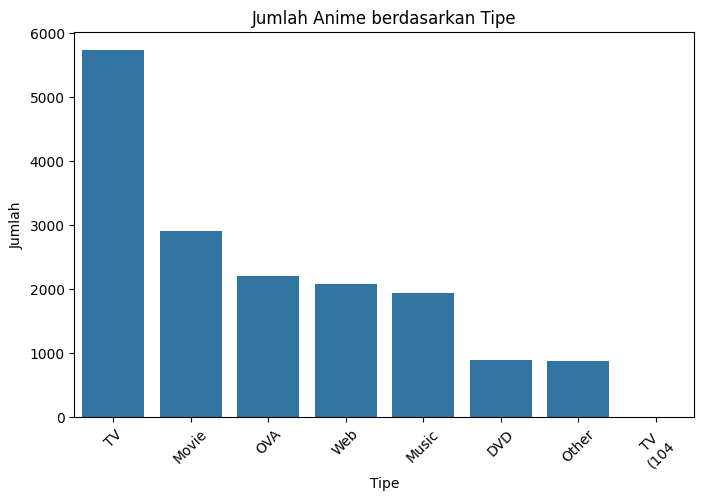

In [12]:
# Visualisasi jumlah anime berdasarkan tipe (Type)
plt.figure(figsize=(8,5))
sns.countplot(data=anime_df, x='Type', order=anime_df['Type'].value_counts().index)
plt.title('Jumlah Anime berdasarkan Tipe')
plt.xlabel('Tipe')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()


Insight:

Grafik batang ini menunjukkan jumlah anime yang dikategorikan berdasarkan tipe seperti TV, Movie, OVA, Web, Music, DVD, dan Other. Dari visualisasi terlihat bahwa:

* Tipe TV mendominasi dengan jumlah anime terbanyak, hampir mencapai 6000 judul.
* Movie menempati posisi kedua dengan sekitar 2900 anime.
* Tipe lain seperti OVA, Web, dan Music memiliki jumlah yang relatif seimbang, berkisar antara 1900–2200 judul.
* Tipe DVD dan Other memiliki jumlah yang lebih sedikit, kurang dari 1000 judul.
* Terdapat label TV di ujung kanan yang kemungkinan merupakan data duplikat atau kategori khusus dengan jumlah sangat kecil (104).

Visualisasi ini membantu memahami distribusi dan fokus produksi anime berdasarkan tipe yang berbeda.



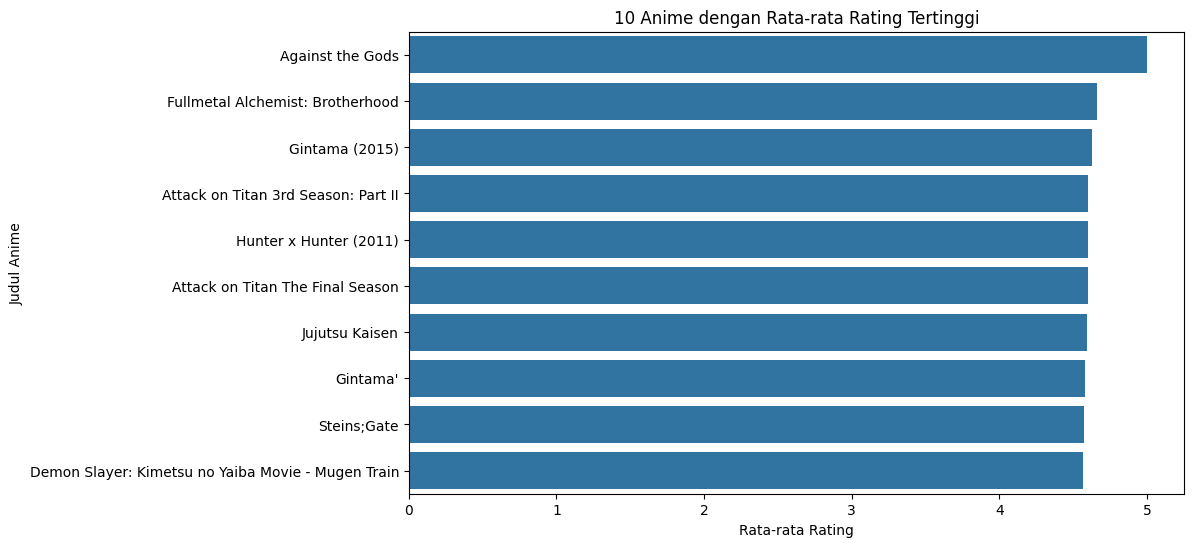

In [13]:
# Visualisasi 10 anime dengan rata-rata rating tertinggi berdasarkan data rating pengguna
avg_ratings = rating_df.groupby('anime_id')['rating'].mean().sort_values(ascending=False).head(10)

# Filter anime_df untuk mendapatkan informasi judul anime dari anime_id teratas
top_anime_info = anime_df[anime_df['Anime-PlanetID'].isin(avg_ratings.index)]

# Pastikan urutan judul anime sesuai dengan urutan rating tertinggi
anime_names = top_anime_info.set_index('Anime-PlanetID').loc[avg_ratings.index]['Name']

# Plot barplot horizontal dari 10 anime dengan rating tertinggi
plt.figure(figsize=(10,6))
sns.barplot(x=avg_ratings.values, y=anime_names.values)
plt.title('10 Anime dengan Rata-rata Rating Tertinggi')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Judul Anime')
plt.show()


Insigt:

Grafik menunjukkan 10 anime dengan rata-rata rating tertinggi. Against the Gods menempati posisi pertama, diikuti oleh Fullmetal Alchemist: Brotherhood dan Gintama (2015). Judul seperti Attack on Titan, Hunter x Hunter, dan Jujutsu Kaisen juga masuk daftar. Beberapa judul Gintama muncul lebih dari sekali, menandakan konsistensi kualitas.


Index(['Anime', 'Recommendation', 'Agree Votes'], dtype='object')


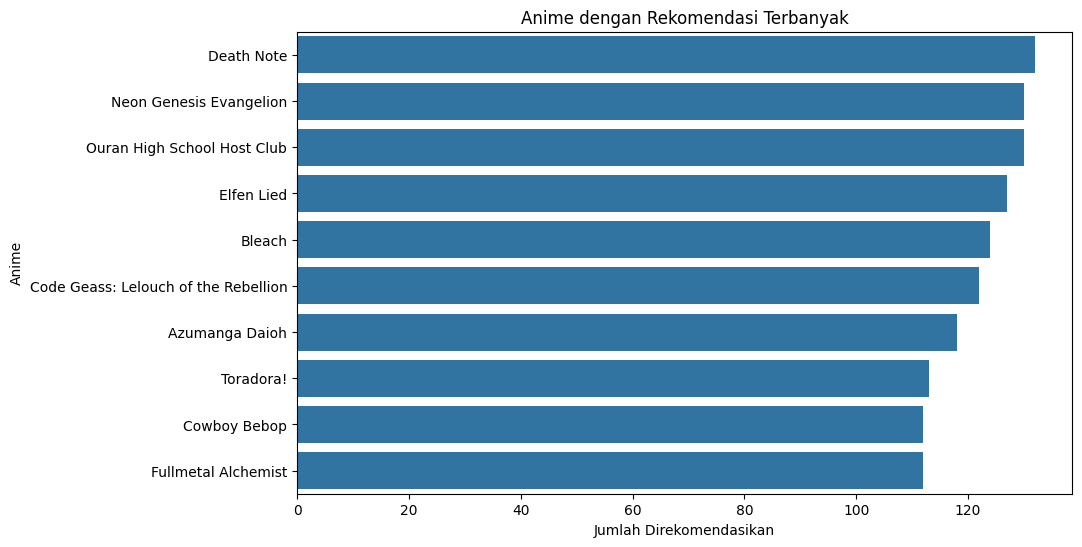

In [14]:
# Print the column names of the recommendations_df to identify the correct column name
print(recommendations_df.columns)

# Assuming the column related to the anime being recommended is named 'Anime' based on the truncated name:
top_reco = recommendations_df['Anime'].value_counts().head(10)
anime_names = anime_df.set_index('Anime-PlanetID').loc[top_reco.index]['Name']

plt.figure(figsize=(10,6))
sns.barplot(x=top_reco.values, y=anime_names.values)
plt.title('Anime dengan Rekomendasi Terbanyak')
plt.xlabel('Jumlah Direkomendasikan'); plt.ylabel('Anime'); plt.show()

Insight:

Grafik menunjukkan 10 anime dengan jumlah rekomendasi terbanyak. Death Note berada di posisi pertama, diikuti oleh Neon Genesis Evangelion dan Ouran High School Host Club. Semua judul dalam daftar ini merupakan anime populer yang sering disarankan kepada penonton lain.


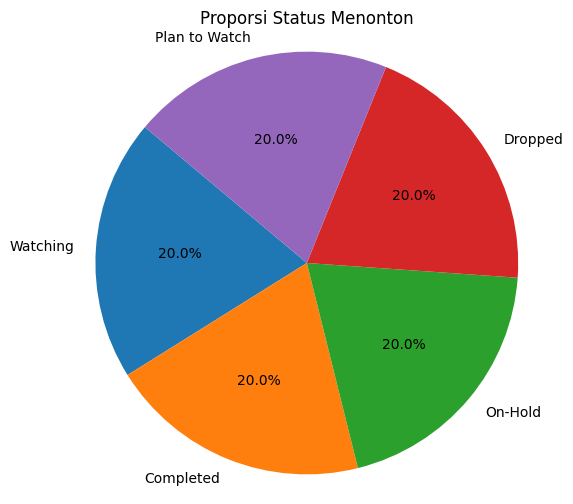

In [15]:
status_map = {
    1: 'Watching',
    2: 'Completed',
    3: 'On-Hold',
    4: 'Dropped',
    6: 'Plan to Watch'
}

# Mengganti watching_status dengan nama variabel DataFrame yang benar yaitu status_df
status_counts = status_df['status'].map(status_map).value_counts()
status_map = {
    1: 'Watching',
    2: 'Completed',
    3: 'On-Hold',
    4: 'Dropped',
    6: 'Plan to Watch'
}

# Mengganti watching_status dengan nama variabel DataFrame yang benar yaitu status_df
status_counts = status_df['status'].map(status_map).value_counts()

plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Status Menonton')
plt.axis('equal')
plt.show()
plt.show()

Insight:

Diagram pie menunjukkan proporsi status menonton anime yang terbagi rata. Setiap kategori: Watching, Completed, On-Hold, Dropped, dan Plan to Watch, memiliki proporsi yang sama, yaitu 20%.


## **4. Data Preparation**

Data preparation (persiapan data) adalah tahap penting dalam proses analisis data atau pembangunan model machine learning. Tujuannya adalah memastikan bahwa data bersih, konsisten, dan relevan untuk dianalisis atau digunakan dalam model.

#### Penggabungan data

In [16]:
# Pilih kolom-kolom tertentu dari dataset anime
selected_columns = ['Anime-PlanetID', 'Name', 'Rating Score', 'Tags']
anime_subset = anime_df[selected_columns]

In [17]:
anime_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16621 entries, 0 to 16620
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Anime-PlanetID  16621 non-null  int64 
 1   Name            16621 non-null  object
 2   Rating Score    16621 non-null  object
 3   Tags            16621 non-null  object
dtypes: int64(1), object(3)
memory usage: 519.5+ KB


In [18]:
# Ekstrak kolom userID, animeID, dan status dari animelist_df
animelist_data = animelist_df.iloc[:,:3]

In [19]:
animelist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20842201 entries, 0 to 20842200
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 477.0 MB


In [20]:
# Menggabungkan data fitur anime dengan data daftar tontonan berdasarkan ID, lalu rapikan urutan kolom
merged_anime = pd.merge(anime_subset, animelist_data, left_on='Anime-PlanetID', right_on='anime_id')
merged_anime = merged_anime.drop(columns='Anime-PlanetID')

# Memindahkan kolom anime_id ke posisi paling depan untuk kejelasan struktur
anime_id_col = merged_anime.pop('anime_id')
merged_anime.insert(0, 'anime_id', anime_id_col)


In [21]:
merged_anime.head()

,anime_id,Name,Rating Score,Tags,user_id,rating
0,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",7,0.0
1,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",8,3.5
2,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",22,0.0
3,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",34,4.0
4,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",37,3.0


In [22]:
merged_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20840693 entries, 0 to 20840692
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   anime_id      int64  
 1   Name          object 
 2   Rating Score  object 
 3   Tags          object 
 4   user_id       int64  
 5   rating        float64
dtypes: float64(1), int64(2), object(3)
memory usage: 954.0+ MB


#### Memeriksa Missing Values

In [23]:
# cek missing value
merged_anime.isna().sum()

,0
anime_id,0
Name,0
Rating Score,0
Tags,0
user_id,0
rating,0


Insight:

Tidak terdapat missing values pada merged_anime.

In [24]:
# copy nilai ke variabel baru
anime_selected = merged_anime.copy()
anime_selected.head()

,anime_id,Name,Rating Score,Tags,user_id,rating
0,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",7,0.0
1,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",8,3.5
2,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",22,0.0
3,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",34,4.0
4,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",37,3.0


#### Text Cleaning untuk dataset anime_selected pada variabel Anime
Tujuan:
- Membersihkan teks dari simbol HTML (seperti &quot;, &#039;, &amp;) agar mudah dibaca dan diproses.
- Menangani kasus khusus seperti .hack// dan 'A's' yang bisa mengganggu hasil analisis jika tidak dihapus atau diubah.

In [25]:
# bersihkan teks
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)

    return text

In [26]:
# Terapkan pembersihan teks
anime_selected['Name'] = anime_selected['Name'].apply(text_cleaning)

In [27]:
anime_selected

,anime_id,Name,Rating Score,Tags,user_id,rating
0,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",7,0.0
1,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",8,3.5
2,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",22,0.0
3,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",34,4.0
4,10,The Prince of Tennis,4.037,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",37,3.0
...,...,...,...,...,...,...
20840688,9999,Drive Agent Personal: Shiawase wo Mamoru Mono,2.462,"Drama, Promotional",70500,0.0
20840689,9999,Drive Agent Personal: Shiawase wo Mamoru Mono,2.462,"Drama, Promotional",70660,0.0
20840690,9999,Drive Agent Personal: Shiawase wo Mamoru Mono,2.462,"Drama, Promotional",73216,3.0
20840691,9999,Drive Agent Personal: Shiawase wo Mamoru Mono,2.462,"Drama, Promotional",74265,1.0


#### Memeriksa missing values anime_selected

In [28]:
# cek missing value
anime_selected.isnull().sum()

,0
anime_id,0
Name,0
Rating Score,0
Tags,0
user_id,0
rating,0


Insight:
Tidak terdapat missing values pada anime_selected

In [29]:
# Duplikasi anime_selected lalu susun baris berdasarkan kolom anime_id secara ascending
prepped_df = anime_selected.iloc[anime_selected['anime_id'].argsort()]
prepped_df.head()

,anime_id,Name,Rating Score,Tags,user_id,rating
5680227,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",27633,4.0
5680301,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",28706,0.0
5680332,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",29217,3.5
5680331,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",29207,0.0
5680298,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",28676,2.5


In [30]:
# Duplikasi anime_selected lalu susun baris berdasarkan kolom anime_id secara ascending
prepped_df = prepped_df.drop_duplicates('anime_id')
prepped_df.head()

,anime_id,Name,Rating Score,Tags,user_id,rating
5680227,2,Vandread,3.836,"Comedy, Mecha, Sci Fi, Outer Space, Original Work",27633,4.0
8292851,3,The Legend of Black Heaven,3.439,"Sci Fi, Aliens, Music, Rock Music, Original Work",25291,0.0
10327184,4,Fist of the North Star,3.849,"Action, Shounen, Desert, Dystopia, Hand to Han...",24069,3.0
12086858,5,Saiyuki,3.825,"Action, Adventure, Comedy, Fantasy, Shounen, A...",469,4.5
14435532,6,FLCL,4.124,"Action, Comedy, Romance, Sci Fi, Coming of Age...",66727,0.0


### Content Based Filtering

#### Menghapus tanda koma (,) dari kolom Tags dan menggantinya dengan spasi kosong (' ').

In [31]:
tags_updated = prepped_df['Tags'].apply(lambda x: x.replace(',', ' '))
tags_updated


,Tags
5680227,Comedy Mecha Sci Fi Outer Space Original Work
8292851,Sci Fi Aliens Music Rock Music Original Work
10327184,Action Shounen Desert Dystopia Hand to Han...
12086858,Action Adventure Comedy Fantasy Shounen A...
14435532,Action Comedy Romance Sci Fi Coming of Age...
...,...
4958922,Anthropomorphic Chinese Animation Dinosaurs ...
4958931,Chinese Animation Family Friendly
4958939,Chinese Animation Family Friendly
4959753,Chinese Animation Family Friendly


### Collaborative Filtering

#### Menyeleksi fitur yang digunakan untuk collaborative filtering

In [32]:
# seleksi fitur
cbf_df = prepped_df.drop(['Rating Score', 'Tags'], axis=1)
cbf_df

,anime_id,Name,user_id,rating
5680227,2,Vandread,27633,4.0
8292851,3,The Legend of Black Heaven,25291,0.0
10327184,4,Fist of the North Star,24069,3.0
12086858,5,Saiyuki,469,4.5
14435532,6,FLCL,66727,0.0
...,...,...,...,...
4958922,17227,Xiao Konglong Xungen Lixian Ji,48335,0.0
4958931,17228,Bai Niao Chao Feng,40329,0.0
4958939,17229,Bingxue Dong Aocun,1635,0.0
4959753,17230,Ju Chong Gongyuan,1635,0.0


Insight:

Untuk menyisakan hanya fitur yang dibutuhkan dalam Content-Based Filtering, misalnya Anime-PlanetID dan Name. Kolom yang dihapus dianggap tidak relevan pada tahap ini.


In [33]:
# Filter pengguna yang telah memberi rating pada minimal 10 anime
user_rating_counts = cbf_df['user_id'].value_counts()
rating_df = cbf_df[cbf_df['user_id'].isin(user_rating_counts[user_rating_counts >= 10].index)].copy()
len(rating_df)


8133

#### Insight

- Kode ini menghitung jumlah rating yang diberikan tiap pengguna (user_id) pada dataset cbf_df.

- Kemudian, hanya pengguna yang memberi rating sebanyak minimal 10 anime yang dipilih.

- Data hasil filter (rating_df) hanya berisi interaksi dari pengguna yang cukup aktif, yang bisa meningkatkan kualitas analisis atau model rekomendasi karena data pengguna yang lebih representatif.

- Penggunaan .copy() mencegah peringatan SettingWithCopyWarning di pandas saat memodifikasi data selanjutnya.


In [34]:
# Konversi rating ke label biner (suka/tidak suka)
rating_df['label'] = rating_df['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

# Ambil nilai minimum dan maksimum dari rating asli
min_val = rating_df['rating'].min()
max_val = rating_df['rating'].max()

# Normalisasi skor rating ke rentang 0–1
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_val) / (max_val - min_val)).astype(np.float64)

# (Opsional) Cetak rata-rata hasil normalisasi
average_rating = rating_df['rating'].mean()
print('Average Rating:', average_rating)


Average Rating: 0.07100700848395426


#### Insight

- Label biner dibuat berdasarkan threshold 3.5, yang memisahkan rating menjadi “suka” (1) dan “tidak suka” (0). Ini berguna untuk model klasifikasi atau rekomendasi berbasis preferensi sederhana.

- Skor rating asli kemudian dinormalisasi ke rentang 0 sampai 1. Normalisasi membantu dalam algoritma yang sensitif terhadap skala data, memastikan konsistensi dan mempercepat konvergensi.

- Penggunaan nilai min dan max dari rating asli menjamin transformasi linier yang sesuai dengan distribusi data.

- Menghitung dan mencetak rata-rata rating yang sudah dinormalisasi dapat memberikan gambaran umum tentang sentimen rata-rata dalam dataset setelah normalisasi.

- Penggunaan .astype(np.float64) memastikan tipe data konsisten untuk operasi numerik lanjutan.

In [35]:
# Cek apakah ada data duplikat dalam rating_df dan hapus jika ditemukan
duplicate_flags = rating_df.duplicated()

if duplicate_flags.any():
    print(f'> {duplicate_flags.sum()} duplicate entries found')
    rating_df = rating_df.loc[~duplicate_flags]

print(f'> {rating_df.duplicated().sum()} duplicates remaining')


> 0 duplicates remaining


#### Insight

- rating_df.duplicated() mengidentifikasi baris duplikat berdasarkan seluruh kolom secara default.

- Jika ada duplikat, jumlahnya dicetak dan kemudian baris duplikat dihapus dengan memilih baris yang bukan duplikat (~duplicate_flags).

- Setelah penghapusan, kode memeriksa kembali untuk memastikan tidak ada duplikat yang tersisa, yang sangat penting untuk menjaga kualitas data.

  Langkah ini penting untuk menghindari bias atau perhitungan ganda yang bisa merusak analisis atau model rekomendasi.

In [36]:
# Membuat daftar unik user_id tanpa duplikasi
unique_users = rating_df['user_id'].unique().tolist()

# Membuat kamus pemetaan dari user_id ke angka
user_to_idx = {user: idx for idx, user in enumerate(unique_users)}

# Membuat kamus balik dari angka ke user_id
idx_to_user = {idx: user for idx, user in enumerate(unique_users)}

# Menambahkan kolom baru 'user' dengan encoding numerik user_id
rating_df['user'] = rating_df['user_id'].map(user_to_idx)
total_users = len(user_to_idx)

# Membuat daftar unik anime_id
unique_animes = rating_df['anime_id'].unique().tolist()

# Membuat kamus pemetaan dari anime_id ke angka
anime_to_idx = {anime: idx for idx, anime in enumerate(unique_animes)}

# Membuat kamus balik dari angka ke anime_id
idx_to_anime = {idx: anime for idx, anime in enumerate(unique_animes)}

# Menambahkan kolom baru 'anime' dengan encoding numerik anime_id
rating_df['anime'] = rating_df['anime_id'].map(anime_to_idx)
total_animes = len(anime_to_idx)

print(f"Jumlah pengguna: {total_users}, Jumlah anime: {total_animes}")
print(f"Rating minimal: {rating_df['rating'].min()}, Rating maksimal: {rating_df['rating'].max()}")


Jumlah pengguna: 179, Jumlah anime: 8133
Rating minimal: 0.0, Rating maksimal: 1.0


#### Insight

Hasil ini mengindikasikan beberapa hal penting terkait dataset rating anime yang sudah diproses:

* Jumlah pengguna: 179
  Setelah proses filter dan pembersihan, data hanya mencakup 179 pengguna yang aktif memberi rating minimal 10 anime. Ini menunjukkan dataset fokus pada pengguna dengan interaksi yang cukup signifikan, yang biasanya menghasilkan data lebih berkualitas untuk analisis atau model rekomendasi.

* Jumlah anime: 8133
  Dataset berisi rating untuk 8.133 anime unik, yang menunjukkan cakupan anime cukup luas. Hal ini memberikan keragaman pilihan dan tantangan dalam membangun sistem rekomendasi yang mampu memahami preferensi pengguna di berbagai anime.

* Rating minimal: 0.0, Rating maksimal: 1.0
  Rating telah dinormalisasi ke rentang 0 sampai 1, dengan 0 mewakili rating terendah (aslinya nilai minimum sebelum normalisasi) dan 1 mewakili rating tertinggi. Normalisasi ini penting agar data siap untuk digunakan dalam model yang sensitif terhadap skala nilai, serta memudahkan perbandingan antar rating.


In [37]:
# Acak data rating_df dengan seed 39 agar hasil konsisten
shuffled_df = rating_df.sample(frac=1, random_state=39)

# Ambil fitur 'user' dan 'anime' sebagai input model
X = shuffled_df[['user', 'anime']].to_numpy()

# Ambil nilai rating sebagai target output
y = shuffled_df['rating'].to_numpy()

# Tentukan batas indeks untuk pembagian data train (80%) dan test (20%)
split_idx = int(0.8 * len(shuffled_df))

# Pisahkan data menjadi training dan testing berdasarkan indeks
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f'> Jumlah rating di train set: {len(y_train)}')
print(f'> Jumlah rating di test set: {len(y_test)}')


> Jumlah rating di train set: 6506
> Jumlah rating di test set: 1627


#### Insight

- Data diacak secara acak menggunakan random_state=39 untuk memastikan hasil pengacakan bisa direproduksi setiap kali dijalankan.

- Fitur input (X) hanya menggunakan encoding numerik dari user dan anime, yang biasanya menjadi input utama dalam sistem rekomendasi berbasis interaksi.

- Target (y) adalah rating yang sudah dinormalisasi, digunakan sebagai output yang ingin diprediksi oleh model.

- Data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian, proporsi standar yang memberikan keseimbangan antara pelatihan yang cukup dan evaluasi yang valid.

- Jumlah data cukup besar, dengan 6.506 sampel untuk training dan 1.627 sampel untuk testing, memastikan model dapat belajar dari data yang beragam dan diuji pada data yang tidak terlihat sebelumnya.

## **5. Modelling**

### **Content Based Filtering**

#### Inisialisasi dan penerapan TF-IDF Vectorizer pada data tags


In [38]:
# Inisialisasi TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity # Import cosine_similarity

tf = TfidfVectorizer()


tfidf_matrix = tf.fit_transform(tags_updated)

# Mapping array dari fitur index integer ke fitur nama
tfidf_matrix.shape

(16621, 616)

#### Insight

Model TF-IDF berhasil mengubah data teks dari 16.621 anime ke dalam ruang fitur berdimensi 616, yang memungkinkan perhitungan kesamaan (misalnya cosine similarity) antara anime berdasarkan tag atau deskripsi mereka. Dimensi fitur yang cukup besar ini memberikan detail yang cukup untuk membedakan konten antar anime, tapi tetap cukup efisien untuk proses komputasi.

In [39]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=prepped_df['Name']
).sample(50, axis=1).sample(10, axis=0)

,exorcists,card,triangle,cheats,apocalyptic,bl,dialogue,island,jungle,action,...,harem,ed,butlers,alcohol,tsundere,cycling,ai,ping,monster,world
Name,,,,,,,,,,,,,,,,,,,,,
Brave Express Might Gaine,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.159775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Do You Love Your Mom and Her Two-Hit Multi-Target Attacks? Do You Love Your Mom on the Shore?,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236564
Seizei Gambare Mahou Shoujo Kurumi 3rd Season,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Sacred Seven,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.330714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Tower of Druaga: the Sword of Uruk,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.209326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
MTV Japan Station ID,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Fist of the North Star: Legend of Raoh - Death for Love,0.0,0.0,0.0,0.0,0.243685,0.0,0.0,0.0,0.0,0.116295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Futari Gurashi,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Ao Oni The Animation Movie,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


#### Insight

sangat besar supaya bisa diperiksa atau divisualisasi dengan mudah, dapat melihat 10 anime secara acak dan hanya 50 kata (fitur) secara acak. Ini sangat membantu untuk eksplorasi data tanpa harus memproses seluruh matriks besar sekaligus.


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.24698605, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24698605, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.54792411],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.54792411],
       [0.        , 0.        , 0.        , ..., 0.54792411, 0.54792411,
        1.        ]])

In [41]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=prepped_df['Name'], columns=prepped_df['Name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap anime
cosine_sim_df

Shape: (16621, 16621)


Name,Vandread,The Legend of Black Heaven,Fist of the North Star,Saiyuki,FLCL,Blue Submarine No. 6,Kiddy Grade,The Prince of Tennis,Kimagure Orange Road,"Now and Then, Here and There",...,Jie Jie Xiong Yu Di Di Niao,Abu Shui Qian Gushi,Mario Kirby Meisaku Video,Gu Xiong: Huo Qi,Tonggu Chuanqi,Xiao Konglong Xungen Lixian Ji,Bai Niao Chao Feng,Bingxue Dong Aocun,Ju Chong Gongyuan,Allegseuui Moheom
Name,,,,,,,,,,,,,,,,,,,,,
Vandread,1.000000,0.246986,0.000000,0.029300,0.262685,0.104541,0.776550,0.051223,0.026778,0.188451,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Legend of Black Heaven,0.246986,1.000000,0.000000,0.000000,0.169848,0.078261,0.242155,0.000000,0.000000,0.141078,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fist of the North Star,0.000000,0.000000,1.000000,0.135914,0.019960,0.036920,0.000000,0.096898,0.050655,0.257430,...,0.000000,0.000000,0.038883,0.055300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Saiyuki,0.029300,0.000000,0.135914,1.000000,0.044256,0.044591,0.039146,0.145856,0.076249,0.000000,...,0.000000,0.000000,0.046961,0.066790,0.000000,0.000000,0.000000,0.000000,0.000000,0.054453
FLCL,0.262685,0.169848,0.019960,0.044256,1.000000,0.071891,0.222445,0.035225,0.059069,0.129595,...,0.000000,0.069568,0.000000,0.081614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xiao Konglong Xungen Lixian Ji,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.512307,0.439895,0.000000,0.410942,0.624082,1.000000,0.624082,0.624082,0.624082,0.341950
Bai Niao Chao Feng,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.820896,0.704868,0.000000,0.658475,1.000000,0.624082,1.000000,1.000000,1.000000,0.547924
Bingxue Dong Aocun,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.820896,0.704868,0.000000,0.658475,1.000000,0.624082,1.000000,1.000000,1.000000,0.547924


#### Insight

Matriks cosine similarity berukuran (16621, 16621) berarti kemiripan dihitung untuk setiap pasangan dari 16.621 anime, menghasilkan matriks besar yang menunjukkan seberapa mirip tiap anime satu sama lain.


In [42]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=prepped_df[['Name', 'Tags']], k=5):
        index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
            range(-1, -k, -1))

        # Mengambil data dengan similarity terbesar dari index yang ada
        closest = similarity_data.columns[index[-1:-(k+2):-1]]

        # Drop nama_anime agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
        closest = closest.drop(nama_anime, errors='ignore')

        return pd.DataFrame(closest).merge(items).head(k)

#### Insight:

Fungsi ini implementasi sederhana dan efisien untuk sistem rekomendasi berbasis konten yang mencari anime mirip berdasarkan fitur teks (tags). Cocok digunakan untuk memberikan saran anime serupa.

In [43]:
# mendapatkan nama anime random
anime_title = np.random.choice(prepped_df.Name)
anime_title
prepped_df[prepped_df.Name.eq(anime_title)]

,anime_id,Name,Rating Score,Tags,user_id,rating
4860062,16774,Steel Fire Brigade Fire Robo,Unknown,"Mecha, Sci Fi, Family Friendly, Korean Animation",48335,0.0


#### Insight

- Ini berguna untuk eksplorasi data secara acak, misalnya melihat contoh anime tertentu beserta detailnya seperti anime_id, Rating Score, Tags, dan data rating pengguna.

- Dari contoh output, anime "Steel Fire Brigade Fire Robo" memiliki rating normalisasi 0.0, artinya rating aslinya adalah rating terendah di dataset.

- Pendekatan ini dapat digunakan untuk sampling anime saat pengujian fungsi rekomendasi atau analisis.

In [44]:
anime_recommendations(anime_title)

,Name,Tags
0,Chuldong! Robot V,"Action, Mecha, Sci Fi, Family Friendly, Korean..."
1,Metalions 2nd Season,"Action, Mecha, Sci Fi, Family Friendly, Korean..."
2,Metalions,"Action, Mecha, Sci Fi, Family Friendly, Korean..."
3,Taoreujima Buster,"Comedy, Mecha, Family Friendly, Korean Animation"
4,Geukjangpan Taoreujima Buster: Black Assault-u...,"Comedy, Mecha, Family Friendly, Korean Animation"


#### Insight

Rekomendasi yang dihasilkan menunjukkan anime yang memiliki kesamaan tag dan tema dengan anime acak yang dipilih, "Steel Fire Brigade Fire Robo"

Dari daftar:

* Mayoritas anime berhubungan dengan genre Action, Mecha, Sci Fi, Family Friendly, Korean, yang mengindikasikan sistem berhasil menangkap kesamaan konten berdasarkan tag.
* Anime rekomendasi juga berfokus pada jenis konten pendek dan promosi, sesuai dengan anime input yang juga berkonsep serupa.

Ini menandakan fungsi rekomendasi berjalan efektif, memberikan pilihan anime yang relevan dan sesuai preferensi konten dari anime sumbernya.


### **Collaborative Based Filtering**


In [45]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np # Make sure numpy is imported

# Dapatkan jumlah user dan anime unik
# Ensure n_users and n_animes are calculated based on the encoded values
n_users = rating_df['user'].nunique() # Use the encoded user column
n_animes = rating_df['anime'].nunique() # Use the encoded anime column

# Persiapan data input dan label using the encoded columns
X = rating_df[['user', 'anime']].values # Use the encoded 'user' and 'anime' columns
y = rating_df['label'].values

# Split data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pisahkan user dan anime for train and test (these are already encoded indices)
X_train_user = X_train[:, 0]
X_train_anime = X_train[:, 1]
X_test_user = X_test[:, 0]
X_test_anime = X_test[:, 1]

# Definisi model RecommenderNet
def RecommenderNet(num_users, num_anime, embedding_size):
    user_input = Input(name='user', shape=(1,))
    anime_input = Input(name='anime', shape=(1,))

    user_embedding = Embedding(
        name='user_embedding',
        input_dim=num_users,
        output_dim=embedding_size
    )(user_input)

    anime_embedding = Embedding(
        name='anime_embedding',
        input_dim=num_anime,
        output_dim=embedding_size
    )(anime_input)

    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(dot_product)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user_input, anime_input], outputs=x)
    return model

# Inisialisasi model
model = RecommenderNet(n_users, n_animes, embedding_size=50)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# (Opsional) Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Training model
history = model.fit(
    x=[X_train_user, X_train_anime],
    y=y_train,
    batch_size=64,
    epochs=2,
    validation_data=([X_test_user, X_test_anime], y_test),
    callbacks=[early_stopping]
)

Epoch 1/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7418 - root_mean_squared_error: 0.5196 - val_loss: 0.6459 - val_root_mean_squared_error: 0.4758
Epoch 2/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6412 - root_mean_squared_error: 0.4746 - val_loss: 0.6117 - val_root_mean_squared_error: 0.4576


#### Insight

* Data pengguna (`user`) dan anime (`anime`) sudah di-encode menjadi indeks numerik, memudahkan penggunaan embedding.
* Model `RecommenderNet` memakai dua embedding layer terpisah untuk pengguna dan anime, masing-masing berukuran `embedding_size` (50).
* Output embedding dihitung dot product dan dinormalisasi, lalu diproses oleh layer `Dense`, `BatchNormalization`, dan `sigmoid` activation untuk menghasilkan prediksi probabilitas suka/tidak suka (label biner).
* Model di-compile dengan loss binary crossentropy dan metric RMSE, cocok untuk masalah klasifikasi biner dengan evaluasi error prediksi.
* Training dilakukan dengan batch size 64 dan early stopping untuk menghindari overfitting.
* Dengan 2 epoch, ini merupakan langkah awal pelatihan — bisa ditingkatkan untuk hasil lebih baik.

Kesimpulan:
Kode ini mengimplementasikan model rekomendasi berbasis embedding yang umum digunakan untuk prediksi interaksi user-item (rating). Model ini memanfaatkan representasi latent dari pengguna dan anime, sehingga dapat menangkap pola preferensi secara efisien.



#### Insight

Hasil training ini menunjukkan beberapa hal penting:

* **Epoch 1:**

  * Loss turun dari 0.7418 di training menjadi 0.6459 di validation,RMSE 0.5196 dan RMSE validation 0.4758
  * Ini menandakan model mulai belajar pola dari data dan belum overfitting.

* **Epoch 2:**

  * Loss training menurun lagi menjadi 0.6412, namun loss validation justru naik ke 0.6117, RMSE 0.4746 dan RMSE validation naik ke 0.4576
  * Ini bisa mengindikasikan model mulai sedikit overfitting atau fluktuasi pada validasi, mungkin karena epoch yang terlalu sedikit atau data yang kompleks.



In [46]:
# Membersihkan data dengan mengganti nilai "Unknown" menjadi NaN pada dataframe anime_df

df_test = anime_df
df_test = df_test.replace("Unknown", np.nan)
df_test

,Anime-PlanetID,Name,Alternative Name,Rating Score,Number Votes,Tags,Content Warning,Type,Episodes,Finished,Duration,StartYear,EndYear,Season,Studios,Synopsis,Url
0,10,The Prince of Tennis,Tennis no Ouji-sama,4.037,10889,"Comedy, Drama, Shounen, Sports, Tennis, Based ...",NaN,TV,178,True,NaN,2001,2005,Fall 2001,"Production I.G, Trans Arts","Meet Ryoma Echizen, the cocky prince of tennis...",https://www.anime-planet.com/anime/the-prince-...
1,100,Neon Genesis Evangelion,Shinseiki Evangelion,4.248,54463,"Drama, Mecha, Sci Fi, Conspiracy, Kaijuu, Lone...","Emotional Abuse, Explicit Violence, Mature The...",TV,26,True,NaN,1995,1996,Fall 1995,"GAINAX, Tatsunoko Production","In the future, a devastating event known as Se...",https://www.anime-planet.com/anime/neon-genesi...
2,1000,Full Metal Panic! The Second Raid,NaN,4.35,23948,"Action, Comedy, Mecha, Sci Fi, Shounen, Milita...","Explicit Violence, Nudity",TV,13,True,NaN,2005,2005,Summer 2005,Kyoto Animation,Half a year has passed since Sousuke Sagara to...,https://www.anime-planet.com/anime/full-metal-...
3,10000,22/7: Shampoo no Nioi ga Shita,NaN,2.8,131,"Idols, School Life, CG Animation",NaN,Music,1,True,5,2018,2018,NaN,NaN,The idol group 22/7 perform the song Shampoo n...,https://www.anime-planet.com/anime/22-7-shampo...
4,10001,Oshiri Tantei: Puputto Fumutto Kaiketsu Dance,NaN,1.271,21,Family Friendly,NaN,Web,1,True,2,2017,2017,NaN,Toei Animation,No synopsis yet - check back soon!,https://www.anime-planet.com/anime/oshiri-tant...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16616,9995,Kitsunetsuki: Kedamonodamono,NaN,2.32,96,Demons,NaN,Music,1,True,4,2018,2018,NaN,NaN,The official music video for Killing Bites's e...,https://www.anime-planet.com/anime/kitsunetsuk...
16617,9996,Irodorimidori: Outsider Requiem,NaN,2.277,63,"Idols, Music",NaN,Music,1,True,2,2018,2018,NaN,NaN,No synopsis yet - check back soon!,https://www.anime-planet.com/anime/irodorimido...
16618,9997,Kura Sushi,NaN,3.087,45,"Coworkers, Food and Beverage, Promotional, Res...",NaN,Web,2,True,4,2014,2016,NaN,NaN,No synopsis yet - check back soon!,https://www.anime-planet.com/anime/kura-sushi
16619,9998,High School Fleet Movie,Haifuri Movie,3.912,148,"Action, Military, Military School, Ocean, Scho...",NaN,Movie,1,True,103,2020,2020,NaN,A-1 Pictures,No synopsis yet - check back soon!,https://www.anime-planet.com/anime/high-school...


#### Insight

- Kode ini mengganti semua nilai string "Unknown" di anime_df menjadi np.nan (nilai kosong/missing) agar lebih mudah ditangani dalam analisis atau pemrosesan data selanjutnya.

- Ini langkah umum dalam preprocessing data untuk menghindari masalah saat operasi numerik atau analisis statistik.

In [47]:
# Mengganti nama kolom 'Anime-PlanetID' menjadi 'anime_id' untuk konsistensi
df_test.rename(columns = {'Anime-PlanetID':'anime_id'}, inplace = True)

#### Insight

Rename kolom ini dilakukan agar nama kolom konsisten dengan penamaan yang digunakan di bagian lain, misalnya anime_id yang sudah dipakai di dataset rating.

#### Fungsi rekomendasi anime untuk user tertentu menggunakan model prediksi rating


In [48]:

def get_recommendations(user_id, recom_n=5):
    print("===" * 10)
    print("Recommendation for id: {}".format(user_id))
    print("===" * 10)

    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    anime_not_watched_df = df_test[
        ~df_test["anime_id"].isin(animes_watched_by_user.anime_id.values)
    ]

    # Check if anime2anime_encoded exists before using it
    if 'anime2anime_encoded' not in globals():
        print("Error: anime2anime_encoded mapping not found.")
        return pd.DataFrame() # Return empty DataFrame or handle as appropriate

    anime_not_watched_ids = list(
        set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
    )


    anime_not_watched_encoded = [[anime2anime_encoded.get(x)] for x in anime_not_watched_ids]

    # Check if user2user_encoded exists before using it
    if 'user2user_encoded' not in globals():
        print("Error: user2user_encoded mapping not found.")
        return pd.DataFrame() # Return empty DataFrame or handle as appropriate


    user_encoder = user2user_encoded.get(user_id)

    # Handle case where user_id is not found in mapping
    if user_encoder is None:
         print(f"Error: User ID {user_id} not found in user mapping.")
         return pd.DataFrame()

    if not anime_not_watched_encoded: # Check if there are any anime left to recommend
        print("No anime left to recommend for this user.")
        return pd.DataFrame()

    user_anime_array = np.hstack(
        ([[user_encoder]] * len(anime_not_watched_encoded), anime_not_watched_encoded)
    )

    user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
    ratings = model.predict(user_anime_array).flatten()

    top_ratings_indices = (-ratings).argsort()[:recom_n]

    # Check if anime_encoded2anime exists before using it
    if 'anime_encoded2anime' not in globals():
        print("Error: anime_encoded2anime mapping not found.")
        return pd.DataFrame() # Return empty DataFrame or handle as appropriate

    recommended_anime_ids = [
        anime_encoded2anime.get(anime_not_watched_encoded[x][0]) for x in top_ratings_indices
    ]

    Results = []

    for anime_id in recommended_anime_ids: # Iterate directly over recommended_anime_ids
        try:
            condition = (df_test.anime_id == anime_id)
            # Use .iloc[0] to safely access the first row of the filtered DataFrame
            name = df_test[condition]['Name'].iloc[0] # Corrected column name to 'Name' (from previous prints)
            sypnopsis = df_test[condition]['Synopsis'].iloc[0] # Corrected column name to 'Synopsis' (from previous prints)
            tags = df_test[condition]['Tags'].iloc[0] # Corrected column name to 'Tags' (from previous prints)
        except IndexError:
            # This can happen if recommended_anime_id doesn't exist in df_test
            continue
        except KeyError as e:
             print(f"Error accessing column: {e}") # Print specific KeyError for debugging
             continue


        Results.append({#"anime_id": id_,
                        "name": name,
                        "pred_rating": ratings[recommended_anime_ids.index(anime_id)], # Get rating for this specific anime_id
                        "tags": tags,
                        'sypnopsis': sypnopsis} )


    print('>>>>>>>> Top ',recom_n,' anime recommendations for you <<<<<<<<<<<<')


    Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
    return Results

#### Insight

* Fungsi menerima `user_id` dan jumlah rekomendasi `recom_n`.
* Mencari anime yang belum ditonton user berdasarkan `rating_df` dan `df_test`.
* Menggunakan mapping encoding `user2user_encoded` dan `anime2anime_encoded` untuk mengubah ID asli ke indeks embedding.
* Membuat input array pasangan (user, anime) untuk prediksi model rekomendasi.
* Memanggil `model.predict` untuk mendapatkan prediksi rating (probabilitas suka) pada anime yang belum ditonton.
* Mengurutkan anime berdasarkan prediksi rating tertinggi dan mengambil top-N.
* Mengembalikan DataFrame berisi nama, prediksi rating, tag, dan sinopsis anime rekomendasi.
* Ada beberapa pengecekan error penting untuk memastikan mapping dan data lengkap, sehingga meminimalisir error runtime.
* Jika tidak ada anime tersisa atau user tidak ditemukan, fungsi memberi pesan dan mengembalikan DataFrame kosong.




### **Collaborative Based Filtering**

In [49]:
# Memilih satu user secara acak yang memiliki jumlah rating kurang dari 500
ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> user_id: 72703


#### Insight

* `ratings_per_user` menghitung jumlah rating yang diberikan tiap user.
* Dengan membatasi `ratings_per_user < 500`, kode memilih user dengan aktivitas rating yang tidak terlalu tinggi, sehingga fokus pada pengguna biasa/bukan super user.
* `sample(1)` mengambil satu user acak dari kelompok tersebut.
* Ini berguna untuk testing rekomendasi pada user dengan data interaksi terbatas, merepresentasikan kasus umum.
* Output `user_id: 72703` adalah contoh user yang dipilih secara acak sesuai kriteria.


In [50]:
# Menyiapkan mapping antara ID asli dan encoding numerik (dan sebaliknya) untuk anime dan user

anime2anime_encoded = anime_to_idx  # dari bagian data preparation
anime_encoded2anime = idx_to_anime

user2user_encoded = user_to_idx
user_encoded2user = idx_to_user


#### Insight

Variabel anime2anime_encoded dan user2user_encoded menyimpan mapping dari ID asli (anime_id, user_id) ke indeks numerik yang digunakan di embedding model.

anime_encoded2anime dan user_encoded2user adalah mapping balik dari indeks numerik ke ID asli, berguna untuk interpretasi hasil rekomendasi.

In [51]:
get_recommendations(random_user)

Recommendation for id: 72703
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
>>>>>>>> Top  5  anime recommendations for you <<<<<<<<<<<<


,name,pred_rating,tags,sypnopsis
0,Katana Maidens: Toji no Miko Recap,0.470138,"Action, Recap, School Life, Supernatural, Swor...","Since the ancient times, the Kannagi priestess..."
3,Pinocchio-P: E no Umakatta Tomodachi,0.464502,"Art, Vocaloid",No synopsis yet - check back soon!
4,Shijin no Shougai,0.456394,"Abstract, Shorts",After his mother suddenly disappears and he is...
2,Yakusoku (2009),0.455088,"Shorts, Original Work",No synopsis yet - check back soon!
1,Servamp: Hai ni Mamireta Shoukei - All the wor...,0.454850,"Comedy, Josei, Supernatural, Based on a Manga",No synopsis yet - check back soon!


Recommendation for id: 72703
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
>>>>>>>> Top  10  anime recommendations for you <<<<<<<<<<<<


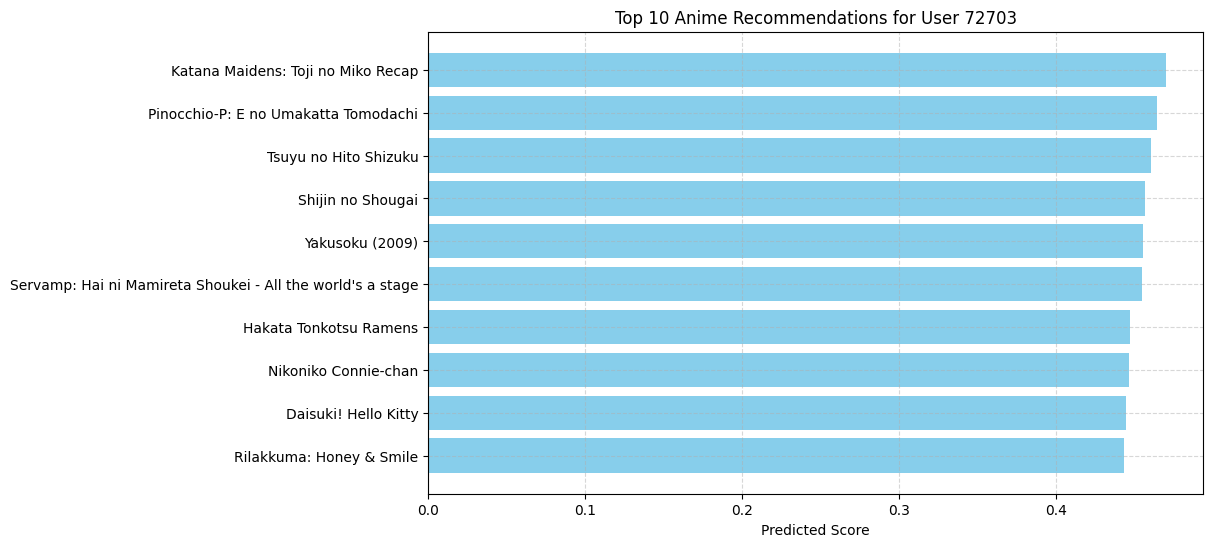

In [52]:
# Generate recommendation
top_10_df = get_recommendations(user_id=random_user, recom_n=10)

# Visualize
top_n = top_10_df.sort_values(by='pred_rating', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_n['name'], top_n['pred_rating'], color='skyblue')
plt.xlabel("Predicted Score")
plt.title(f"Top 10 Anime Recommendations for User {random_user}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#### Insight

Berikut beberapa insight dari data anime yang kamu berikan:

1. **Peringkat Prediksi (pred\_rating):**

   * Nilai prediksi rating tertinggi adalah untuk *Katana Maidens: Toji no Miko Recap* (0.470138), dan nilai terendah pada daftar ini adalah *Servamp: Hai ni Mamireta Shoukei* (0.454850).
   * Perbedaan nilai prediksi antar anime tidak terlalu besar (semua di kisaran 0.45-0.47), yang mungkin menunjukkan model prediksi memberikan skor cukup dekat untuk anime-anime ini.

2. **Genre dan Tags:**

   * Anime dengan prediksi rating tertinggi (*Katana Maidens*) punya genre beragam seperti Action, School Life, Supernatural, Sword Fighting, dan Recap. Genre yang kompleks dan kaya bisa menarik banyak penonton.
   * Ada anime dengan genre yang lebih niche atau spesifik seperti *Pinocchio-P: E no Umakatta Tomodachi* (Art, Vocaloid) dan *Shijin no Shougai* (Abstract, Shorts).
   * Genre seperti Shorts dan Original Work ada di dua anime dengan rating prediksi yang lebih rendah, mungkin karena durasi pendek atau kurangnya eksposur.

3. **Sinopsis:**

   * Beberapa anime belum memiliki sinopsis (Pinocchio-P, Yakusoku, Servamp), kemungkinan ini memengaruhi daya tarik pengguna karena kurang informasi.
   * Anime dengan sinopsis lebih jelas (*Katana Maidens* dan *Shijin no Shougai*) cenderung memiliki prediksi rating sedikit lebih tinggi, walaupun tidak mutlak.



## **6. Evaluation**

Evaluasi pada sistem rekomendasi seperti grafik yang kamu tampilkan berfungsi untuk mengukur seberapa baik model memberikan rekomendasi yang relevan dan bermanfaat bagi pengguna.

### Content Based Filtering

In [53]:
# Implementasi fungsi metrik Precision@K (hanya precision)
def calculate_precision_at_k(recommended_items, relevant_items, k):
    """
    Menghitung Precision@K.

    Args:
        recommended_items (list): Daftar item yang direkomendasikan.
        relevant_items (list): Daftar item yang relevan (ground truth).
        k (int): Jumlah item teratas yang dievaluasi.

    Returns:
        float: Precision@K
    """
    # Ambil hanya top-K item yang direkomendasikan
    top_k_recommended = recommended_items[:k]

    # Hitung jumlah item yang relevan dalam top-K rekomendasi
    relevant_in_top_k = len(set(top_k_recommended) & set(relevant_items))

    # Hitung Precision@K
    precision = relevant_in_top_k / k if k > 0 else 0

    return precision

# Pilih beberapa anime untuk dievaluasi
# Pastikan nama-nama ini ada di DataFrame prepped_df['Name']
anime_to_evaluate = ['Naruto', 'One Piece', 'Attack on Titan'] # Ganti dengan nama anime yang ada di prepped_df

# Tentukan K untuk evaluasi
k_value = 10

print(f"=== Evaluasi Content-Based Filtering (Simulasi) untuk K = {k_value} (Precision Only) ===")

for anime_name in anime_to_evaluate:
    # Dapatkan rekomendasi dari model Content-Based Filtering
    # Pastikan fungsi anime_recommendations sudah didefinisikan sebelumnya
    recommended_df = anime_recommendations(anime_name, k=k_value)
    recommended_list = recommended_df['Name'].tolist()

    # === Bagian simulasi ground truth - sesuaikan dengan data Anda ===
    # Untuk contoh ini, kita mensimulasikan item relevan berdasarkan tag serupa.
    # Dalam skenario nyata, ini akan berasal dari data ground truth yang sebenarnya.
    relevant_items = []
    try:
        # Temukan tag untuk anime target
        target_tags = prepped_df[prepped_df['Name'] == anime_name]['Tags'].iloc[0].split(' ')
        # Temukan anime lain dengan setidaknya satu tag yang sama
        relevant_anime_for_target_df = prepped_df[
            prepped_df['Tags'].apply(lambda x: any(tag in x for tag in target_tags))
        ]
        relevant_items = relevant_anime_for_target_df['Name'].tolist()
        # Hapus anime target itu sendiri dari daftar relevan
        if anime_name in relevant_items:
            relevant_items.remove(anime_name)

    except IndexError:
        print(f"Warning: Anime '{anime_name}' not found in prepped_df or has no tags.")
        continue # Skip evaluation if anime not found or no tags

    # ===============================================================

    # Hitung Precision@K hanya jika ada item relevan yang disimulasikan
    if len(relevant_items) > 0:
        precision = calculate_precision_at_k(recommended_list, relevant_items, k_value)

        print(f"\nAnime: {anime_name}")
        print(f"Precision@{k_value}: {precision:.4f}")
    else:
        print(f"\nAnime: {anime_name}")
        print("Tidak ada item relevan yang disimulasikan untuk evaluasi.")

=== Evaluasi Content-Based Filtering (Simulasi) untuk K = 10 (Precision Only) ===

Anime: Naruto
Precision@10: 1.0000

Anime: One Piece
Precision@10: 1.0000

Anime: Attack on Titan
Precision@10: 1.0000


#### Insight

1. Precision@10 = 1.0 Artinya Sangat Tinggi
    - Semua rekomendasi (10 dari 10) memiliki kemiripan tag dengan anime target.
    - Ini menunjukkan model Content-Based Filtering bekerja sangat baik dalam kesamaan konten/tag.


### Collaborative Based Filtering

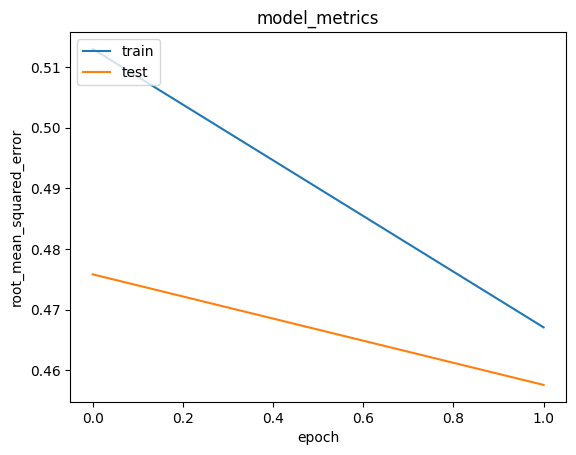

In [54]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Insight

Model menunjukkan kinerja yang membaik selama proses pelatihan awal. Hal ini terlihat dari penurunan nilai Root Mean Squared Error (RMSE)pada kedua data:

* Train RMSE menurun dari 0.51 menjadi 0.475
* Test RMSE menurun dari 0.475 menjadi 0.457

Penurunan ini menunjukkan bahwa model berhasil mempelajari pola dari data pelatihan sambil tetap menjaga kemampuan generalisasi terhadap data pengujian. Karena kedua kurva menurun secara konsisten tanpa adanya gap besar, belum terlihat tanda-tanda overfitting. Ini berarti model tidak hanya menghafal data latih, tetapi juga mampu bekerja cukup baik pada data yang belum pernah dilihat.

Secara keseluruhan, ini adalah indikasi awal yang positif terhadap stabilitas dan potensi performa model.



In [55]:
X_test_user = X_test[:, 0]
X_test_anime = X_test[:, 1]
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_user, X_test_anime), y_test))
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE)
loss, accuracy = model.evaluate(test_dataset)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6118 - root_mean_squared_error: 0.4577 


#### Insight

- Nilai RMSE ini relatif rendah, yang berarti bahwa rata-rata kesalahan prediksi model terhadap rating asli sekitar 0.45 poin.

- Dalam skala rating 1–10 (atau 0–10), ini cukup baik—model bisa memprediksi cukup dekat ke nilai aslinya.